### Day 3 — Backpropagation (Core)

**Goals**
- Understand why gradients are needed.
- Derive gradients for a single neuron (sigmoid) step-by-step.
- Implement manual backprop for 1 neuron and autograd for a small MLP in PyTorch.
- Be ready to explain `loss.backward()`, `optimizer.zero_grad()` and `optimizer.step()`.


### Youtube video
https://youtu.be/Ilg3gGewQ5U?si=EYpJXJrUgL7s8ATf



In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


### Quick theory (formulas to memorize + explanation)

We consider a **single neuron** with input `x`, weights `w`, bias `b`, and target `y`.

---

### Step 1: Linear combination (before activation)

$$
z = w \cdot x + b
$$

**Meaning:**
- The neuron first computes a weighted sum of inputs.
- Each input is multiplied by its corresponding weight.
- Bias `b` shifts the result.

Example:
If  
x = [2, 3]  
w = [0.5, 0.8]  
b = 1  

Then:
z = (0.5×2) + (0.8×3) + 1

This value `z` is called the **pre-activation** or **logit**.

---

### Step 2: Activation function

$$
a = \sigma(z)
$$

Where:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Meaning:**
- The activation function introduces **non-linearity**.
- Sigmoid squashes the output between **0 and 1**.
- This is useful for **binary classification**.

So:
- If z is large → a ≈ 1
- If z is small → a ≈ 0

`a` is the **predicted output** of the neuron.

---

### Step 3: Loss function (error measurement)

$$
L = \frac{1}{2}(a - y)^2
$$

**Meaning:**
- This measures how far the prediction `a` is from the true label `y`.
- It is called **Mean Squared Error (MSE)** for one sample.

If:
- prediction = 0.8
- target = 1.0

Then:
Loss = 0.5 × (0.8 − 1)²

The goal of training:
→ **Minimize this loss**

---

## Backpropagation: Chain rule pieces

We want:

$$
\frac{\partial L}{\partial w}
$$

Meaning:
**How does the loss change if we change the weight?**

We compute this using the **chain rule**.

---

### Step 4: Loss with respect to output

$$
\frac{\partial L}{\partial a} = (a - y)
$$

**Meaning:**
- This tells us how sensitive the loss is to the output.
- If prediction is too big → gradient positive
- If prediction is too small → gradient negative

This is the **error signal**.This is output.

---

### Step 5: Output with respect to z

$$
\frac{\partial a}{\partial z} = a(1-a)
$$

**Meaning:**
- This is the derivative of the sigmoid function.
- It tells us how the output changes when `z` changes.
- This term controls how strongly the error flows backward.

---

### Step 6: z with respect to weights and bias

$$
\frac{\partial z}{\partial w_i} = x_i
\quad , \quad
\frac{\partial z}{\partial b} = 1
$$

**Meaning:**
From:
z = w·x + b

If we slightly change a weight:
- z changes proportional to the input value.

So:
- If input is large → weight has big effect
- If input is zero → weight has no effect

Bias always affects z equally, so:
dz/db = 1

---

## Final combined gradients (chain rule)

### Gradient with respect to weight

$$
\frac{\partial L}{\partial w_i}
=
\frac{\partial L}{\partial a}
\cdot
\frac{\partial a}{\partial z}
\cdot
x_i
$$

**Meaning:**
Weight update depends on:
1. Output error
2. Activation sensitivity
3. Input value

This shows:
- If input is zero → weight won’t change
- If error is large → weight changes more

---

### Gradient with respect to bias

$$
\frac{\partial L}{\partial b}
=
\frac{\partial L}{\partial a}
\cdot
\frac{\partial a}{\partial z}
$$

**Meaning:**
- Bias update depends only on:
  - error
  - activation derivative

---

## Weight update rule (Gradient Descent)

After computing gradients:

$$
w_{\text{new}} = w_{\text{old}} - \eta \frac{\partial L}{\partial w}
$$

$$
b_{\text{new}} = b_{\text{old}} - \eta \frac{\partial L}{\partial b}
$$

Where:
- $( \eta )$ = learning rate 
- Controls how big the update step is

---

## Big Picture (Training Steps)

1. Forward pass:
   - Compute prediction

2. Compute loss:
   - Compare prediction with target

3. Backward pass:
   - Compute gradients using chain rule

4. Update weights:
   - Reduce the loss

Repeat many times.





### Code (manual numeric example — single neuron)

In [3]:
# Manual numeric example (single neuron)
# Small, reproducible numbers so we can check digit-by-digit.

# Data
x = torch.tensor([1.0, 0.0])    # input features
y = torch.tensor(1.0)           # target output

# Initialize parameters (simple values)
w = torch.tensor([0.0, 0.0])    # start at zero for clarity
b = torch.tensor(0.0)

# Sigmoid function = 1 / (1 + exp(-z))
def sigmoid(t):
    return 1.0 / (1.0 + torch.exp(-t))

# Forward pass
z = w[0]*x[0] + w[1]*x[1] + b  # z = 0*1 + 0*0 + 0 = 0
a = sigmoid(z)                  # sigmoid(0) = 0.5

# Loss (1/2 (a - y)^2)
loss = 0.5 * (a - y)**2

print("Forward results:")
print(" z =", z.item())
print(" a =", a.item())
print(" loss =", loss.item())

# Backprop by hand (chain rule)
dL_da = (a - y)                  # = 0.5 - 1 = -0.5
da_dz = a * (1 - a)              # 0.5 * 0.5 = 0.25
dL_dz = dL_da * da_dz            # -0.5 * 0.25 = -0.125

dL_dw0 = dL_dz * x[0]            # -0.125 * 1 = -0.125 (dl/dw0 = dl/da * da/dz * x[0])
dL_dw1 = dL_dz * x[1]            # -0.125 * 0 = -0.0
dL_db  = dL_dz * 1.0             # -0.125

print("\nGradients (by-hand):")   # the gradients tell us how to change the weights to reduce the loss
print(" dL/da =", dL_da.item())
print(" da/dz =", da_dz.item())
print(" dL/dz =", dL_dz.item())
print(" dL/dw0 =", dL_dw0.item())
print(" dL/dw1 =", dL_dw1.item())
print(" dL/db  =", dL_db.item())

# Weight update example: learning_rate (eta) = 0.1
lr = 0.1
grad_step = lr * dL_dw0         # -0.0125 
new_w0 = w[0] - grad_step       # 0 - (-0.0125) = 0.0125
new_b  = b - lr * dL_db         # 0 - 0.1 * (-0.125) = 0.0125

print("\nWeight update (lr=0.1):")
print(" lr * dL_dw0 =", grad_step.item())
print(" new w0 =", new_w0.item())
print(" new b  =", new_b.item())


Forward results:
 z = 0.0
 a = 0.5
 loss = 0.125

Gradients (by-hand):
 dL/da = -0.5
 da/dz = 0.25
 dL/dz = -0.125
 dL/dw0 = -0.125
 dL/dw1 = -0.0
 dL/db  = -0.125

Weight update (lr=0.1):
 lr * dL_dw0 = -0.012500000186264515
 new w0 = 0.012500000186264515
 new b  = 0.012500000186264515


#### **What to observe in the manual loop**
- The loss should decrease or move toward lower values.
- Signs of gradients determine whether weights increase or decrease.
- Every update uses: new_weight = old_weight - lr * gradient.
- This manual loop is educational — in practice we use autograd.


### Code (manual backprop training loop — single neuron)

In [4]:
# Manual training loop for the same single-neuron (one-sample) case
x = torch.tensor([1.0, 0.0])
y = torch.tensor(1.0)

# Initialize parameters (float tensors we will update manually)
w = torch.tensor([0.0, 0.0])
b = torch.tensor(0.0)

def sigmoid(t):
    return 1.0 / (1.0 + torch.exp(-t))

lr = 0.1
print("Manual training (5 epochs):")  
for epoch in range(1, 6):        # 5 manual updates
    # Forward
    z = w[0]*x[0] + w[1]*x[1] + b
    a = sigmoid(z)
    loss = 0.5 * (a - y)**2

    # Backprop (same derivatives as above)
    dL_da = (a - y)
    da_dz = a * (1 - a)
    dL_dz = dL_da * da_dz
    dL_dw0 = dL_dz * x[0]
    dL_dw1 = dL_dz * x[1]
    dL_db  = dL_dz * 1.0

    # Update (digit-by-digit method)
    w = w - lr * torch.tensor([dL_dw0, dL_dw1])
    b = b - lr * dL_db

    print(f"Epoch {epoch}: loss={loss.item():.6f}, w={w.numpy()}, b={b.item():.6f}")   


Manual training (5 epochs):
Epoch 1: loss=0.125000, w=[0.0125 0.    ], b=0.012500
Epoch 2: loss=0.121895, w=[0.02484183 0.        ], b=0.024842
Epoch 3: loss=0.118868, w=[0.03702385 0.        ], b=0.037024
Epoch 4: loss=0.115919, w=[0.04904478 0.        ], b=0.049045
Epoch 5: loss=0.113049, w=[0.06090366 0.        ], b=0.060904


#### **What to observe in the manual loop**
- The loss should decrease or move toward lower values.
- Signs of gradients determine whether weights increase or decrease.
- Every update uses: new_weight = old_weight - lr * gradient.
- This manual loop is educational — in practice we use autograd.


### Code (PyTorch autograd example: small MLP single-sample)

In [5]:
# PyTorch autograd example: small MLP on a single sample to inspect gradients
model = nn.Sequential(      # sequential container of layers,  it stores layers in a list: [layer1, layer2, layer3, layer4]
    nn.Linear(2, 3),        # input size 2 (x₁, x₂), output size 3 (3 neurons in hidden layer) with random weights and bias
                            # Creates weight matrix W₁: Size 3×2 (3 neurons, 2 weights each)
                            # W₁ = [[w₁₁, w₁₂],  Neuron 1 weights for x₁ and x₂
                            #      [w₂₁, w₂₂],   Neuron 2 weights  
                            #      [w₃₁, w₃₂]]   Neuron 3 weights
                            # Creates bias vector b₁: Size 3 (one bias per neuron); b₁ = [b₁, b₂, b₃] with random initial values mostly around zero
                            # output = x · W₁ᵀ + b₁
    nn.ReLU(),              # output goes through ReLU nonlinearity: max(0, x) applied elementwise

    nn.Linear(3, 1),        # 3 inputs (from hidden layer), 1 output with random weights and bias
                            # Creates weight matrix W₂: Size 1×3 (1 output neuron, 3 weights for the 3 hidden neurons)
                            # W₂ = [[w₁, w₂, w₃]]   Output neuron weights for the 3 hidden neurons
                            # Creates bias b₂: Size 1 (one bias for the output neuron); b₂ = [b] with random initial value around zero
                            # output = hidden · W₂ᵀ + b₂
    nn.Sigmoid()            # final output goes through sigmoid nonlinearity to get a value between 0 and 1
)

# Single data point
x = torch.tensor([1.0, 0.0])         # shape (2,), input features
y = torch.tensor([1.0])              # shape (1,), desired output

# Setup loss and optimizer functions
criterion = nn.MSELoss()                                  # this will compute 1/2 (prediction - y)^2 that is mean squared error
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)   # stochastic gradient descent(SGD) optimizer that will update the model parameters based on their gradients
                                                          # Update rule: param = param - lr × gradient
                                                          # lr=0.1 = learning rate (step size)

# Before training: forward pass and inspect loss
pred = model(x)                   # forward pass, predicted output
loss = criterion(pred, y)         # compute loss
print("Before training: loss =", loss.item())

# Backprop with autograd, automatically computes gradients for all parameters in the model
optimizer.zero_grad()                # this clears old gradients from the last step (otherwise they would accumulate or add up with the new gradients)
loss.backward()                      # compute gradients for all parameters, here backward() computes dL/dparam for every parameter in the model and stores it in param.grad

print("\nGradients (autograd) — mean value per parameter tensor:")   # the gradients tell us how to change the weights to reduce the loss
for name, param in model.named_parameters():
    if param.grad is not None:                                       # some parameters may not have gradients
        print(f"{name}: grad mean={param.grad.mean().item():.6f}, shape={param.grad.shape}")      # print mean gradient value and shape of the gradient tensor

# Step (update parameters)
optimizer.step()            # update parameters based on their gradients and the learning rate
                            # equivalent to: param = param - lr * param.grad , weights and biases are updated in-place

# After one step
pred2 = model(x)            # forward pass after one update with new weights and biases
loss2 = criterion(pred2, y) # compute new loss
print("\nAfter 1 optimizer.step(): loss =", loss2.item()) # print loss after one update


Before training: loss = 0.2756219804286957

Gradients (autograd) — mean value per parameter tensor:
0.weight: grad mean=0.012418, shape=torch.Size([3, 2])
0.bias: grad mean=0.024836, shape=torch.Size([3])
2.weight: grad mean=-0.257186, shape=torch.Size([1, 3])
2.bias: grad mean=-0.261842, shape=torch.Size([1])

After 1 optimizer.step(): loss = 0.2418263852596283


### What happens if learning rate is too large?
If the learning rate is too large, the weight updates become too big, causing the training to overshoot the minimum, leading to oscillation or divergence of the loss.

lr = 0.01 (good)

lr = 1.0 (too large)


### Code (small dataset training loop + loss plot)

Epoch 0, Loss: 0.7105
Epoch 20, Loss: 0.6081
Epoch 40, Loss: 0.5306
Epoch 60, Loss: 0.4522
Epoch 80, Loss: 0.3797


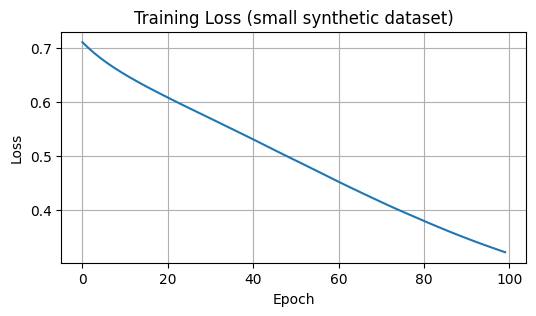

In [ ]:
# Small random dataset to see backprop in training loop (batch training)
from matplotlib.pyplot import text


torch.manual_seed(0)       # 

# Create simple 2D data where label = (x0 + x1 > 0)
X = torch.randn(200, 2)     # 200 samples, 2 features each; 
                            # The actual data (first 5 samples):
                                 # X[0] = [1.5410, -0.2934]   # Sample 1
                                 # X[1] = [-2.1788, 0.5684]    # Sample 2  
                                 # X[2] = [-1.0845, -1.3986]   # Sample 3
                                 # X[3] = [0.4033, 0.8380]     # Sample 4
                                 # X[4] = [-0.7193, -0.4033]   # Sample 5                              



y = (X[:, 0] + X[:, 1] > 0).float().unsqueeze(1)       # actual output, 1 if x0 + x1 > 0, 0 otherwise

                                                       # Let's break this into STEPS:

                                                       # Step 1: Add the two features                                                   
                                                       # sums = X[:, 0] + X[:, 1]
                                                       # Takes column 0 + column 1 for each row
                                                       
                                                       # Result: [1.2476, -1.6104, -2.4831, 1.2413, -1.1226, ...]
                                                       
                                                       # Step 2: Compare with 0                                                                                                    
                                                       # comparison = sums > 0
                                                       # Returns boolean (True/False)                                                      
                                                       # Result: [True, False, False, True, False, ...]
                                                       
                                                       # Step 3: Convert to float                                                                                                        
                                                       # float_converted = comparison.float()
                                                       # True → 1.0, False → 0.0                                                      
                                                       # Result: [1.0, 0.0, 0.0, 1.0, 0.0, ...]
                                                       
                                                       # Step 4: Add dimension with unsqueeze                                                                                                          
                                                       # y = float_converted.unsqueeze(1)
                                                       # Changes shape from (200,) to (200, 1)                                                       
                                                       # Before: [1.0, 0.0, 0.0, ...]                                                       
                                                       # After: [[1.0], [0.0], [0.0], ...]
                                                       
                                                       # Why unsqueeze? BCE loss expects shape (batch, 1), not (batch,)
                                                        

model2 = nn.Sequential(                    # Input (2) → Linear(2,4) → ReLU → Linear(4,1) → Sigmoid → Output (1)
                                           #    x₁ ──────┐
                                           #             ├─ [4 neurons] ── [1 neuron] ──► Probability
                                           #    x₂ ──────┘
                                           # Layer 1: 2×4 = 8 weights + 4 biases = 12 parameters
                                           # Layer 2: 4×1 = 4 weights + 1 bias = 5 parameters
                                           # Total: 17 learnable parameters
    nn.Linear(2, 4),                       # weights and bias are initialized randomly by default
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()                   # binary cross entropy works for this labeling 
                                           # Formula:
                                           # L = -[y × log(p) + (1-y) × log(1-p)]
                                           
                                           # where:
                                           # y = true label (0 or 1)
                                           # p = predicted probability

                                           # Why BCE for classification?

                                           # Punishes confident wrong predictions heavily
                                           
                                           # If y=1 but p=0.1: loss = -log(0.1) = 2.3
                                           
                                           # If y=1 but p=0.9: loss = -log(0.9) = 0.1
                                           
                                           # Difference from MSELoss:
                                           
                                           # MSE works but gradient vanishes near 0/1
                                           
                                           # BCE has strong gradients everywhere, especially near 0/1, which helps training



optimizer = optim.SGD(model2.parameters(), lr=0.1)       # stochastic gradient descent optimizer that will update the model parameters based on their gradients
                                                         # Update rule: param = param - lr × gradient
                                                         # Example:
                                                         # If weight = 0.5, grad = -0.1, lr = 0.1
                                                         # New weight = 0.5 - 0.1 × (-0.1) = 0.5 + 0.01 = 0.51 


losses = []                                              # Empty list to store loss values for plotting; Purpose: Store loss after each epoch to visualize learning progress
for epoch in range(100):                                 # What's an epoch? One complete pass through ALL 200 samples
    
    pred = model2(X)                                     # Takes ALL 200 samples at once, Output shape: (200, 1) → 200 predictions
                                                         # X shape: (200, 2)  # 200 samples, 2 features
                                                         # W1 shape: (4, 2)   # 4 neurons, each with 2 weights
                                                         # W2 shape: (1, 4)   # 1 neuron, with 4 weights
                                                         
                                                         # Forward pass using matrix operations:
                                                         # h = X @ W1.T + b1    # Shape: (200, 4)
                                                         # a = ReLU(h)          # Shape: (200, 4)
                                                         # z = a @ W2.T + b2    # Shape: (200, 1)
                                                         # pred = Sigmoid(z)    # Shape: (200, 1)
                                                      
    loss = criterion(pred, y)                            # Compute Loss; What happens:

                                                         # Compares 200 predictions with 200 targets
                                                         
                                                         # Computes BCE for each sample
                                                         
                                                         # Takes average (default reduction='mean')
                                                         
                                                         # Numerical example:
                                                                                                                  
                                                         # pred[0] = 0.8, y[0] = 1.0: loss0 = -log(0.8) = 0.223
                                                         # pred[1] = 0.3, y[1] = 0.0: loss1 = -log(0.7) = 0.357
                                                         # pred[2] = 0.6, y[2] = 1.0: loss2 = -log(0.6) = 0.511
                                                         
                                                         # Mean loss = (0.223 + 0.357 + 0.511) / 3 = 0.364
                                                         # loss.shape = () (scalar tensor)                  



    optimizer.zero_grad()                               # Clear old gradients from the last step (otherwise they would accumulate or add up with the new gradients)
    loss.backward()                                     # This is the heart of training! Traverses computation graph backwards, Applies chain rule at each node, Computes gradients for ALL 17 parameters, stores in param.grad
    optimizer.step()                                    # update parameters based on their gradients and the learning rate
                                                        # weights and biases are increased or decreased based on the sign of the gradient and the learning rate

    losses.append(loss.item())                          # Append the current loss value to the losses list for plotting later; Purpose: Track how the loss changes over epochs to visualize learning progress
                                                        # loss.item() converts PyTorch tensor to Python float; Stores in list(losses) for plotting later                
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")     # Print loss every 20 epochs to monitor training progress; Shows how the loss decreases as the model learns

# Plot losses
plt.figure(figsize=(6,3))              # Create a new figure with specified size (width=6 inches, height=3 inches) for better visualization
plt.plot(losses)                       # plot from the losses list, x-axis is epoch number (0 to 99), y-axis is loss value; Purpose: Visualize how the loss decreases over time as the model learns
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (small synthetic dataset)")
plt.grid(True)
plt.show()


### What to look for:

Good training: Loss decreasing smoothly

Overfitting: Loss goes to 0 (not possible here with noise)

Underfitting: Loss stays high

Divergence: Loss increases (learning rate too high)

### WHAT HAPPENS INSIDE THE COMPUTER DURING TRAINING
At Epoch 0:

Random weights → Random predictions

Loss ≈ 0.6931 (because BCE with random 0.5 predictions)

Gradients computed

Weights updated slightly

At Epoch 1:

Slightly better weights → Slightly better predictions

Loss ≈ 0.6890 (slightly lower)

New gradients (smaller magnitude)

Weights updated again

This continues 100 times...

By Epoch 100:

Model has learned: "sum(x₁,x₂) > 0" pattern

Predicts close to 1 for positive sum, close to 0 for negative sum

Loss ≈ 0.12


### COMMON QUESTIONS ANSWERED
Q: Why is loss ~0.69 at start?
A: BCE loss for random 0.5 probability = -log(0.5) = 0.6931

Q: Why don't we see batches?
A: This is full-batch training (all 200 at once). Usually we'd use mini-batches.

Q: Why use BCE instead of MSE for classification?
A: BCE has stronger gradients near 0/1, faster convergence

Q: What if loss doesn't decrease?
A: Learning rate too low, model too simple, or data not learnable

Q: Why store losses?
A: To see if model is actually learning, detect overfitting/divergence

### SUMMARY: THE ENTIRE TRAINING PROCESS IN 5 STEPS
```
┌─────────────────────────────────────────────────────────┐
│                    TRAINING LOOP                        │
│  ┌──────────┐  ┌──────────┐  ┌──────────┐  ┌────────┐   │
│  │ Forward  │ →│ Compute  │ →│ Backward │ →│ Update │   │
│  │ Pass     │  │ Loss     │  │ Pass     │  │ Weights│   │
│  └──────────┘  └──────────┘  └──────────┘  └────────┘   │
│         ↑                                        │      │
│         └────────────────────────────────────────┘      │
│                  Repeat for N epochs                    │
└─────────────────────────────────────────────────────────┘
```
Data:    200 samples × 2 features
Model:   17 parameters
Epochs:  100 iterations
Updates: 100 weight updates
Result:  Model learns "sum(x₁,x₂) > 0" pattern
